In [1]:
%load_ext autoreload
%autoreload 2

import sys
import logging
logger = logging.getLogger()
logger.setLevel(logging.INFO)
handler = logging.StreamHandler(sys.stderr)
formatter = logging.Formatter('%(name)s - %(levelname)s - %(message)s')
handler.setFormatter(formatter)
logger.handlers = [handler]

In [11]:
import os
# Setting env variables
os.environ['CXRDATA']='/dfs/scratch0/jdunnmon/data/mmtl/cxr'
os.environ['CXR8IMAGES']='/lfs/1/jdunnmon/data/nih/images/images_heq'
os.environ['NERDDIMAGES']='/lfs/1/jdunnmon/cxr/data/nerdd/preproc_224_cxr_h5'

In [12]:
from metal.mmtl.cxr.analysis.notebooks.cxr_analysis import load_log_json, load_results_from_log
from metal.mmtl.cxr.cxr_tasks import create_tasks_and_payloads
# Loading results from model log
model_log = '/lfs/1/jdunnmon/repos/metal/logs/2019_05_09/soft_param_negative_drain_slice_cnn_all_classes_09_33_10/'
log_jsons = load_results_from_log(model_log)
task_config = log_jsons['task_config']
task_config.update(
    {
    'tasks': ['NERDD-CHEST-TUBE_CHEST_TUBE'],
    'active_slice_heads':{'pred':False, 'ind':False},
    'model_type': 'naive',
    'slice_dict': {},
    'load_pos_only':False,
    'slice_pos_only': [],
    'train_sampler': 'imbalanced_sampler',
        }
    )
nerdd_task_names = task_config['tasks']

In [13]:
nerdd_tasks, nerdd_payloads = create_tasks_and_payloads(nerdd_task_names, **task_config, batch_size=16)
#_ = [a.remove_label_set('NERDD-CHEST-TUBE_NERDD_LABEL') for a in nerdd_payloads]
#task_config['tasks'] = list(nerdd_payloads[0].labels_to_tasks.keys())
#nerdd_tasks = [t for t in nerdd_tasks if t.name in task_config['tasks']]

/lfs/1/jdunnmon/repos/anaconda3/envs/metal/lib/python3.6/site-packages/torchvision/models/densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  nn.init.kaiming_normal(m.weight.data)
/lfs/1/jdunnmon/repos/anaconda3/envs/metal/lib/python3.6/site-packages/torchvision/transforms/transforms.py:188: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  "please use transforms.Resize instead.")


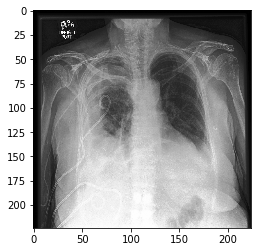

In [15]:
import matplotlib.pyplot as plt
img = nerdd_payloads[0].data_loader.dataset[5][0]['data']
plt.imshow(img[0,:,:],cmap='gray')

In [7]:
log_jsons['model_config']

{'seed': '1701',
 'device': 0,
 'verbose': False,
 'fp16': False,
 'model_weights': None,
 'model_type': 'soft_param',
 'delete_heads': False}

In [8]:
from metal.mmtl.metal_model import MetalModel
# Initializing the model
model_config = log_jsons['model_config'] 
model_config.update({'model_type':'naive', 'model_weights': None})
model = MetalModel(tasks=nerdd_tasks, **model_config)

In [29]:
#print(nerdd_payloads[0].data_loader.sampler.weights.unique())
#print(1/np.sum(nerdd_payloads[0].data_loader.dataset.labels['NERDD-CHEST-TUBE_CHEST_TUBE']==2))

tensor([1.5463e-04, 1.7703e-05], dtype=torch.float64)
1.7703188344220794e-05


In [31]:
model

MetalModel(
  (input_modules): ModuleDict(
    (NERDD-CHEST-TUBE_CHEST_TUBE): DataParallel(
      (module): MetalModuleWrapper(
        (module): TorchVisionEncoder(
          (model): DenseNet(
            (features): Sequential(
              (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
              (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (relu0): ReLU(inplace)
              (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
              (denseblock1): _DenseBlock(
                (denselayer1): _DenseLayer(
                  (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
                  (relu1): ReLU(inplace)
                  (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
                  (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

In [32]:
from metal.mmtl.trainer import MultitaskTrainer
trainer_config = log_jsons['config'] 

trainer_config['n_epochs']=20
trainer_config['checkpoint_config']['checkpoint_dir']='checkpoints_temp'
trainer_config['writer_config']['run_name'] = 'test_slice_train_exp'
trainer_config['optimizer_config']['optimizer_common']['lr'] = 0.001
# Initializing trainer 
trainer = MultitaskTrainer(**trainer_config)

In [33]:
# Training model
trainer.train_model(model, nerdd_payloads)

metal.mmtl.trainer - INFO - Training on training set...
metal.mmtl.trainer - INFO - Beginning train loop.
metal.mmtl.trainer - INFO - Expecting a total of approximately 62960 examples and 3935 batches per epoch from 1 payload(s) in the train split.
metal.mmtl.trainer - INFO - Initializing new log writer...
/lfs/1/jdunnmon/repos/metal/metal/mmtl/trainer.py:645: UserWarning: You have provided checkpoint_dir, overriding the default of using log_dir/run_dir/run_name/checkpoints. Be careful: multiple concurrent runs may override each other.
  warnings.warn(msg)
metal.logging.writer - INFO - Writing config to /lfs/1/jdunnmon/repos/metal/logs/2019_05_17/test_slice_train_exp_02_01_44/config.json
metal.mmtl.trainer - INFO - Training all modules...
metal.mmtl.trainer - INFO - Training tasks {'NERDD-CHEST-TUBE_CHEST_TUBE': 'NERDD-CHEST-TUBE_CHEST_TUBE'}
Exception ignored in: <generator object tqdm_notebook.__iter__ at 0x7f7eac82c518>
Traceback (most recent call last):
  File "/lfs/1/jdunnmon/repo

KeyboardInterrupt: 

## SANDBOX

In [24]:
import numpy as np
ind = 15
dsn = nerdd_payloads[0].data_loader.dataset
img_n = dsn[15][0]['data']
img_n = np.array(img_n)
print(f'Max: {max(img_n.flatten())}, Min: {min(img_n.flatten())}')

Max: 1.6963894367218018, Min: -1.5882478952407837


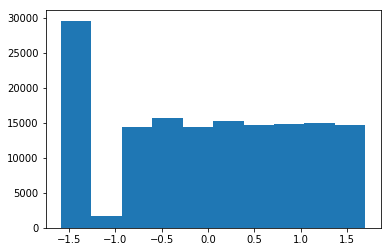

In [25]:
import matplotlib.pyplot as plt
plt.hist(img_n.flatten())
plt.show()

In [26]:
img_n.shape

(3, 224, 224)

In [9]:
import pandas as pd
import numpy as np
import os

def split_dataframe(df, seed=1701):
    """
    Creates train, test, dev split from single dataframe
    """
    return np.split(df.sample(frac=1, random_state=seed), [int(.6*len(df)), int(.8*len(df))])

def print_class_balance(df, lab_col, split):
    counts = df.groupby(lab_col)[lab_col].count()
    bals = {k:v/len(df) for k,v in counts.items()}
    for k,v in bals.items():
        print(f'Split {split}, Class {k}: {np.round(v*100,2)} Percent')
    
# LOADING DATA AND OUTPUTTING TRAIN/TEST/DEV
dfs = {}
splits = ['train','dev','test']
nerdd_data_path = os.path.join(os.environ['CXRDATA'],'NERDD-CHEST-TUBE')
df_tube = pd.read_csv(os.path.join(nerdd_data_path,'chest_tube_master.csv'), index_col=0)
df_tube['img_path'] = df_tube['img_path'].apply(lambda x: '/'.join(x.split('/')[-2:]))
dfs['train'], dfs['dev'], dfs['test'] = split_dataframe(df_tube)
_ = [print_class_balance(dfs[split], 'chest_tube', split) for split in splits]

# Outputting to CSV
#for split in splits:
#    dfs[split].to_csv(os.path.join(nerdd_data_path,f'{split}.tsv'),sep='\t')

Split train, Class 1: 10.27 Percent
Split train, Class 2: 89.73 Percent
Split dev, Class 1: 10.02 Percent
Split dev, Class 2: 89.98 Percent
Split test, Class 1: 10.6 Percent
Split test, Class 2: 89.4 Percent


## DATALOADER FROM NIH

In [17]:
import torch
from torch.autograd import Variable
import os

import numpy as np

from metal.mmtl.cxr.analysis.notebooks.cxr_analysis import load_log_json, load_results_from_log
from metal.mmtl.cxr.cxr_tasks import create_tasks_and_payloads

In [18]:
# Loading results from model log
model_log = '/lfs/1/jdunnmon/repos/metal/logs/2019_05_09/soft_param_negative_drain_slice_cnn_all_classes_09_33_10/'
log_jsons = load_results_from_log(model_log)

In [27]:
task_config = log_jsons['task_config']
task_config['subsample'] = -1
task_config['eval_finding'] = 'ALL'
task_names=['CXR8-DRAIN_ALL']
task_config['sample_dict']={}
#{"train_sample_dict":{'PNEUMOTHORAX':-1,'ALL':300}}
                            #"valid_sample_dict":{'PNEUMOTHORAX':-1,'ALL':300}}
task_config['add_normal_col']=True
task_config['slice_dict']={"CXR8-DRAIN_PNEUMOTHORAX": ["chest_drain_cnn_neg"]}
task_config['slice_pos_only']=['NONE']
task_config['active_slice_heads']={'pred':True,'ind':False}
task_config['verbose']=True
#task_config['train_sampler'] = "imbalanced_mmtl_sampler"
tasks, payloads = create_tasks_and_payloads(task_names, **task_config, batch_size=16)

/lfs/1/jdunnmon/repos/anaconda3/envs/metal/lib/python3.6/site-packages/torchvision/models/densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  nn.init.kaiming_normal(m.weight.data)
/lfs/1/jdunnmon/repos/anaconda3/envs/metal/lib/python3.6/site-packages/torchvision/transforms/transforms.py:188: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  "please use transforms.Resize instead.")


In [34]:
ind = 60001
ds = payloads[0].data_loader.dataset
img = ds[ind][0]['data']

In [35]:
ds.transform

Compose(
    Scale(size=224, interpolation=PIL.Image.BILINEAR)
    CenterCrop(size=(224, 224))
    ToTensor()
)

In [36]:
img = np.array(img)

In [37]:
print(f'Max: {max(img.flatten())}, Min: {min(img.flatten())}')

Max: 1.7341532707214355, Min: -1.7490626573562622


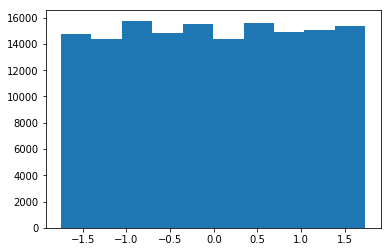

In [38]:
import matplotlib.pyplot as plt
plt.hist(img.flatten())
plt.show()

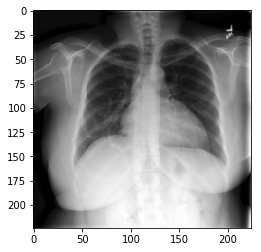

In [23]:
plt.imshow(img[0,:,:],cmap='gray')

In [23]:
from PIL import Image
import numpy as np

img_orig = Image.open(os.path.join(ds.path_to_images, ds.df.index[ind]))
#img_orig = img_orig.convert("RGB")

arr = np.array(img_orig)

In [27]:
print(f'Max: {max(arr.flatten())}, Min: {min(arr.flatten())}')

Max: 255, Min: 0


In [25]:
import matplotlib.pyplot as plt
plt.hist(img_orig.flatten())
plt.show()

AttributeError: 'PngImageFile' object has no attribute 'flatten'

In [26]:
import skimage.exposure
eq = skimage.exposure.equalize_hist(np.array(img_orig))

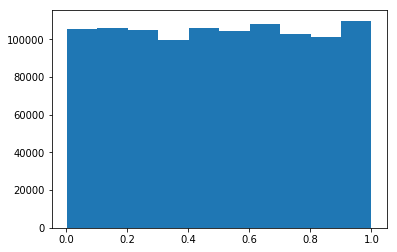

In [62]:
import matplotlib.pyplot as plt
plt.hist(np.array(eq).flatten())
plt.show()

In [81]:
import scipy.misc
scpimg = scipy.misc.toimage(eq,mode='P')
scpimg.save('test.png',format='png')

/lfs/1/jdunnmon/repos/anaconda3/envs/metal/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: `toimage` is deprecated!
`toimage` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use Pillow's ``Image.fromarray`` directly instead.
  


In [76]:
np.array(scpimg)-np.array(img_orig)

array([[219, 219, 219, ..., 214, 215, 203],
       [219, 219, 219, ..., 214, 216, 203],
       [219, 219, 219, ..., 212, 214, 203],
       ...,
       [222, 221, 221, ..., 222, 234, 204],
       [222, 220, 221, ..., 222, 232, 204],
       [222, 220, 220, ..., 222, 230, 205]], dtype=uint8)

In [77]:
np.array(img_orig)

array([[178, 179, 180, ..., 157, 159, 100],
       [174, 172, 178, ..., 156, 161,  99],
       [174, 171, 171, ..., 152, 158,  98],
       ...,
       [197, 194, 193, ..., 198, 213, 140],
       [197, 192, 193, ..., 197, 211, 139],
       [198, 192, 191, ..., 198, 209, 141]], dtype=uint8)

In [79]:
np.array(scpimg)

array([[141, 142, 143, ..., 115, 118,  47],
       [137, 135, 141, ..., 114, 121,  46],
       [137, 134, 134, ..., 108, 116,  45],
       ...,
       [163, 159, 158, ..., 164, 191,  88],
       [163, 156, 158, ..., 163, 187,  87],
       [164, 156, 155, ..., 164, 183,  90]], dtype=uint8)

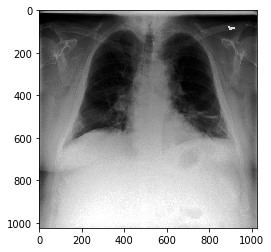

In [84]:
plt.imshow(np.array(scpimg),cmap='gray')

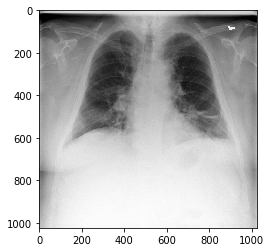

In [86]:
plt.imshow(np.array(img_orig),cmap='gray')

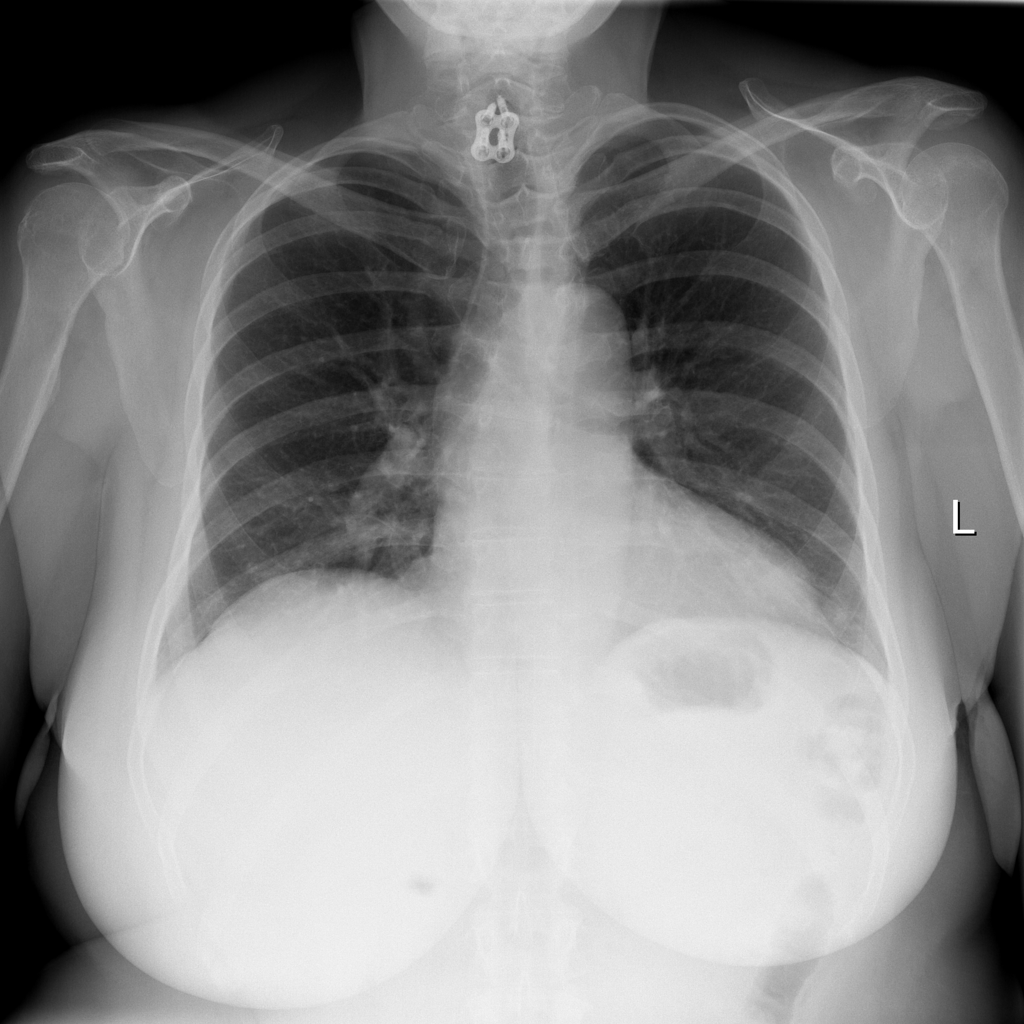

In [89]:
a = Image.open('/lfs/1/jdunnmon/data/nih/images/images/00006351_002.png')
a

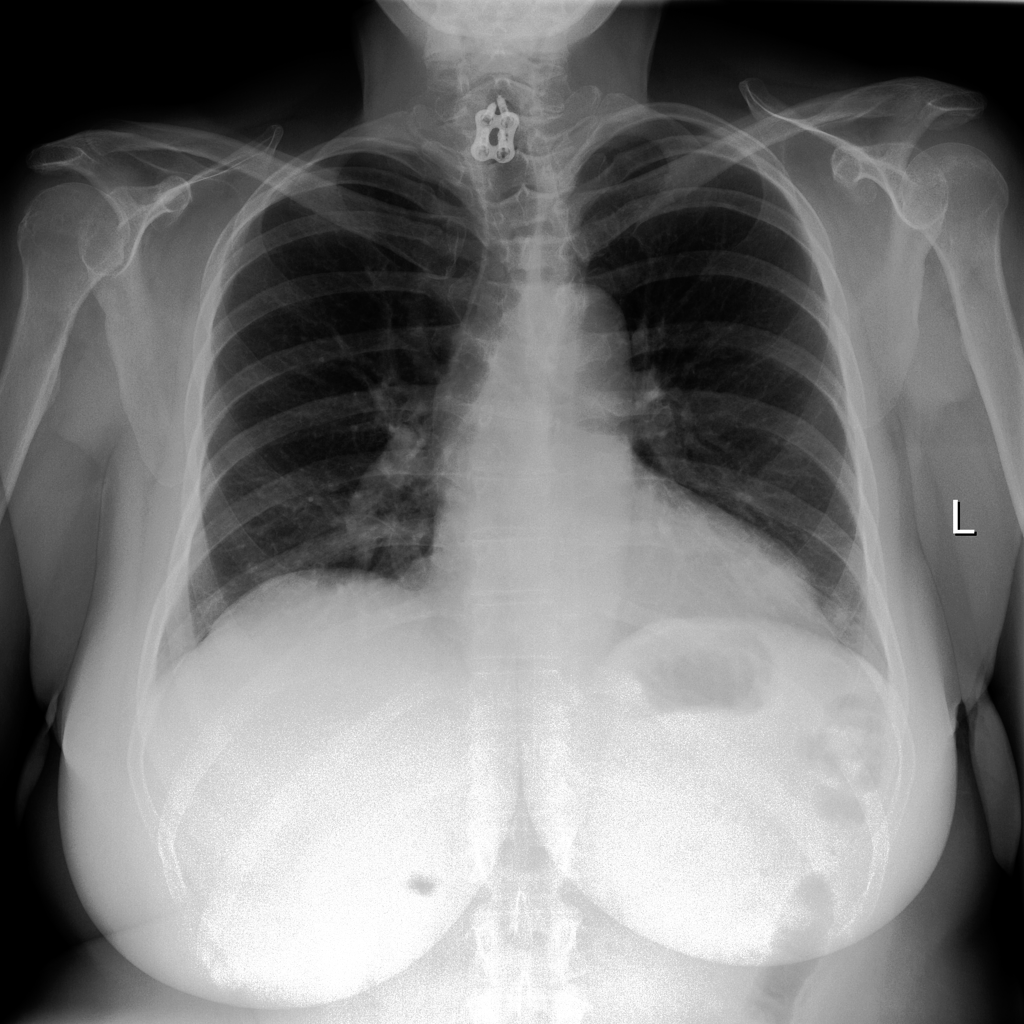

In [91]:
b = Image.open('/lfs/1/jdunnmon/data/nih/images/images_heq/00006351_002.png')
b

In [99]:
np.array(a)

array([[  0,   0,   0, ..., 185, 187, 191],
       [  0,   0,   0, ..., 153, 155, 157],
       [  0,   0,   0, ..., 113, 116, 115],
       ...,
       [  0,   1,   4, ...,  15,  16,  13],
       [  1,   4,   7, ...,  15,  14,  11],
       [  4,   8,   9, ...,  14,  12,   8]], dtype=uint8)

In [100]:
np.array(b)

array([[  0,   0,   0, ..., 165, 167, 170],
       [  0,   0,   0, ..., 136, 138, 140],
       [  0,   0,   0, ...,  86,  90,  88],
       ...,
       [  0,   0,   1, ...,   4,   4,   3],
       [  0,   1,   2, ...,   4,   4,   3],
       [  1,   2,   2, ...,   4,   3,   2]], dtype=uint8)

In [ ]:
self.dataset.labels